# SolasAI Disparity Introduction

## Quick Start Summary

This example serves as an introductory text aiming to teach a user how to measure disparities with the SolasAI library. While the example in this notebook is based on the calculation of a single metric, the Adverse Impact Ratio (AIR), there are numerous other metrics available in SolasAI, as well as a generic metric interface for developing custom disparity metrics. Usage of the other metrics is discussed in other examples.

This notebook provides:

1. A short background on terms used throughout the SolasAI library.

2. An explanation of how to import and call functionality in the SolasAI disparity testing library. 

3. An example of how to calculate an Adverse Impact Ratio using U.S. Home Mortgage Disclosure Act (HMDA) data.

4. An overview of how to make customized or formatted tables and charts using the SolasAI disparity testing library.

## Background

Before jumping into the code, we provide a short explanation of several terms used in the code.


### "Protected" and "Reference" Groups

In SolasAI's current list of curated metrics, there is an assumption that one will test whether some group(s) achieve outcomes that are _at least as good_ as another group's outcomes. The first group(s), identified in SolasAI as `protected_groups`, typically consists of people who have been or are continuing to experience some form of discrimination or disadvantage.  The outcomes of these groups are then compared to those of the `reference_groups`, which typically have not been subject to the same type of discrimination or disadvantages.

Outside SolasAI, there are numerous ways that these classifications are made and described. For example, often the word "protected" may be replaced with "minority", "disadvantaged", "test", or some other description, while "reference" may be replaced with "majority", "advantaged", "control", or some other description. Our use of the "protected" and "reference" categorization comes from our experience working in litigation and regulatory compliance in the United States. It is not meant to imply any particular value judgement regarding the classifications used.

A third attribute, `group_categories` is also used throughout the SolasAI library to delineate between different protected-reference group combinations. For example, `group_categories` might be race, sex, age, medical diagnoses, etc. By way of example, classifications most commonly used by SolasAI's U.S. customers are:

<center/>

| `group_categories` | `protected_group` | `reference_group` |
|--------------------|-------------------|-------------------|
| Race               | Black             | White             |
| Race               | Hispanic          | White             |
| Race               | Asian             | White             |
| Sex / Gender       | Female            | Male              |
| Age                | Age >= X          | Age < X           |
</center>



### Outcomes, Labels, and Segments

SolasAI can be used to measure disparities created as the result of automated systems, semi-automated systems, or entirely subjective processes.  Regardless of the use case, when the user calculates disparity, they will need to specify the `outcome` attribute.  In some cases, this will be a binary (i.e., "Yes" or "No") outcome, such as whether a person was offered a job, loan, or sent a marketing offer.  In other cases, it may be a continuous value, such as a model's probability of loan default, the amount of time it takes for a person to be promoted, or an employee's pay rate.  Of the metrics SolasAI provides, some are appropriate for the binary case (e.g., `adverse_impact_ratio`), while others are appropriate for analyses of continuous values (e.g., `standardized_mean_difference`).

When measuring disparities that arise from the use of a model, and when the true outcome is known, a user can specify the `label` attribute.  Certain metrics, such as the `residual_standardized_mean_difference`, require the label to be present because the disparity measurement incorporates the label.

Some metrics, including the `segmented_adverse_impact_ratio` perform analyses on subsets of the data and then aggregate the results.  SolasAI refers to these subsets using the `segment` attribute.  Examples of segments might be different store locations, job openings, or job types.  Care should be used when deciding whether to incorporate segmentation into an analysis.

### Statistical Significance and Practical Significance

SolasAI uses thresholds of statistical significance and "practical" significance to determine whether any potential disparities found are sufficiently large to warrant further review.  The SolasAI does not provide guidance as to which standards are appropriate.  What constitute appropriate and reasonable standards may be driven by regulatory and legal requirements, business decisions, or other factors.  We suggest consulting with one's compliance department, legal advisors, or consultants such as [BLDS, LLC](https://www.bldsllc.com/) (the consultancy from which SolasAI was founded) for advice.

That said, after one decides what thresholds to use, SolasAI allows users to test whether the disparity metrics exceed those thresholds.  In the case of statistical significance, each metric uses a measurement of statistical significance that is appropriate or commonly used for that metric.  As an example, in the case of the AIR, statistical significance is calculated using either a Fisher's Exact test or a Chi-Squared test (depending on the size of the data).  For the SMD, a t-test is used.  In certain cases, the user can specify either the test itself or certain attributes of the test.  In United States legal and regulatory standards, a two-sided p-value less than 5% (or, equivilently, a one-sided p-value less than 2.5%) is generally considered statistically significant.  SolasAI does not provide guidance on whether this standard is reasonable or appropriate for any particular use case.

Importantly, for SolasAI to identify that a result is "practically significant", it must _both_ be found to be statistically significant and exceed the practical significance thresholds set.  Most metrics in SolasAI provide the option to specify two thresholds.  The first is a `percent_difference_threshold`.  If a user sets a value greater than zero, then the raw difference in outcomes between the protected and reference groups must exceed a particular value before a result is considered practically significant.  For example, if `percent_difference_threshold = 0.02` for the AIR, and we find that Black applicants receive offers 1% of the time, but White applicants receive them 2.5% of the time, then this disparity will not be significant because the difference in outcomes is only 1.5%, which is less thna the 2% threshold.  

The second practical significance metric relates to the value of the metric itself.  For example, when calling the `adverse_impact_ratio`, one sets the `air_threshold` to a particular value.  In the example below, we use `air_threshold=0.80`.  This means that only results that are statistically significantly different from parity _and_ that have AIR values less than 0.80 will be considered practically significant.

## Importing the Library and Data for Use in the Analysis

Below, we import the `pandas` and `plotly` libraries used to prepare and graph the data.  SolasAI relies on the plotly library for graphing.  The final line of code, `pio.renderers.default = 'svg'` is only necessary because this workbook is hosted in GitHub, which cannot render plotly graphics in their native format.

In [1]:
import pandas as pd
import plotly.io as pio
pio.renderers.default = "svg"

SolasAI's disparity library is imported just like any standard Python package.  Here, we import the library itself, which will be accessed as `sd`.  Within sd, we will also access several other types of functions, including:

1. The interface functionality, `sd.ui`, which allows users to do things like create nicely formatted tables.
2. The SolasAI constants file, `sd.const`, which allows users to customize numerous settings including column names and plot headings.
3. Access to a set of utility functions, `sd.util`, which provide additional useful functionality.


In [2]:
import solas_disparity as sd

### Data Preparation

The following code imports a sample of the 2018 Home Mortgage Disclosure Act (HMDA) data.  The HMDA dataset includes information about nearly every home mortgage application in the United States.  This dataset includes information about the mortgage itself, such as the loan term and APR; information about credit characteristics of the borrowers themselves, including the borrowers income and debt-to-income (DTI) ratio; and information about the home being purchased, such as its location and the value of the property.  Importantly, it also includes information about each borrower's race, gender, and ethnicity.  The data we are using is based only for applications where the borrower was approved for the loan.

In [3]:
df = pd.read_csv("data/hmda.csv.gz", index_col="id")
df.sample(random_state=161803, n=5)

,Low-Priced,Interest Rate,Rate Spread,Loan Amount,Loan-to-Value Ratio,No Intro Rate Period,Intro Rate Period,Property Value,Income,Debt-to-Income Ratio,...,Hawaiian Or Pacific Islander,Hispanic,Non-Hispanic,Male,Female,Age >= 62,Age < 62,Race,Ethnicity,Sex
id,,,,,,,,,,,,,,,,,,,,,
13451,1.0,0.04875,0.00596,155000.0,0.9700,1,0,165000.0,35000.0,0.33,...,0.0,1.0,0.0,1.0,0.0,NaN,NaN,White,Hispanic,Male
18248,1.0,0.05750,0.01268,305000.0,1.0000,1,0,295000.0,60000.0,0.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown
19610,1.0,0.05500,0.01214,485000.0,0.9500,1,0,515000.0,100000.0,0.43,...,0.0,0.0,1.0,NaN,NaN,1.0,0.0,White,Non-Hispanic,Unknown
3339,1.0,0.03875,-0.00087,675000.0,1.0000,1,0,675000.0,190000.0,0.33,...,0.0,0.0,1.0,NaN,NaN,0.0,1.0,Black,Non-Hispanic,Unknown
19675,1.0,0.04375,0.00076,275000.0,0.3507,1,0,775000.0,209000.0,0.25,...,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown


We next specify the groups that we will use to test disparities.  In SolasAI, each protected and reference group must be its own variable in the input data.  These variable names are then included in the `protected_group`, `reference_group`, and `group_categories` lists that are used throughout the SolasAI library.

For example, if we are going to test for evidence of disparities between Black and White applicants, we must have one variable that identifies whether the person represented by the observation is Black and one variable that identifies whether the person is White.  Importantly, missing values for these characteristics are generally allowed in SolasAI.  

While more groups are available for analysis in the HMDA data, we limit the analysis in order to make the output more tractable.  The categorization used in this example is as follows:

<center/>

| `group_categories` | `protected_group` | `reference_group` |
|--------------------|-------------------|-------------------|
| Race               | Black             | White             |
| Race               | Native American   | White             |
| Race               | Asian             | White             |
| Sex                | Female            | Male              |
| Ethnicity          | Hispanic          | Non-Hispanic      |

</center>

The three lists must all be the same length, with each element of the list corresponding to the same comparison (e.g., the first element of the lists below have `Black`, `White` and `Race`, meaning that Black applicants are being compared to White applicants, which is a comparison by race. The fifth elements of each list are `Female`, `Male`, and `Sex`, which means that women are being compared to men, and the type of comparison is by Sex).


In [4]:
protected_groups = ["Black", "Asian", "Native American", "Hispanic",     "Female"]
reference_groups = ["White", "White", "White",           "Non-Hispanic", "Male"]
group_categories = ["Race",  "Race",  "Race",            "Ethnicity",    "Sex"]

While not demonstrated in this notebook, a key benefit to the SolasAI library is its ability to calculate disparities on groups where the characteristics are estimated, rather than known.  

In this case, each person's probability estimates are put into the fields identifying group membership.  For example, if the estimation procedure finds that a person has a 75% chance of being Black and a 25% chance of being White, then that person's Black and White variables would have values of 0.75 and 0.25, respectively.

A common example of this occurs in race and ethnicity estimation, where a person's home address and last name are used to calculate the probability that the person is Black or White (This is known as the Bayesian Improved Surname Geocoding ("BISG") method.  See [here](https://github.com/cfpb/proxy-methodology) for more detail).  

## Calculating the Adverse Impact Ratio on Prior Lending Decisions

Determining whether there is evidence of discrimination requires, to the extent possible, testing a model or process before it is put into use as well as testing it when it is being used in production (i.e., having an effective monitoring process).  In this example, we focus on how an organization would monitor a process that is already in production.  Here, we use the HMDA data to test whether there is evidence that members of the protected groups were less likely to receive low-priced loans than members of the reference groups.

This type of analysis can be performed on subjective decisions, such as loan officer decisions to underwrite a loan, or a manager deciding whom to promote.  It can also be performed on the outcomes of automated decisioning processes, such as the use of a model to screen applicants, give job offers, or some other similar process.  It can also be performed on a model's training or validation datasets prior to the model being used in production.

Below, we use the `sd.adverse_impact_ratio` function to calculate the AIR:

In [5]:
air = sd.adverse_impact_ratio(
    group_data=df,  # dataset containing the protected and reference group information
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=group_categories,
    outcome=df["Low-Priced"],
    sample_weight=None,
    air_threshold=0.80,
    percent_difference_threshold=0,
)

## Overview of SolasAI Disparity Objects with the AIR as an Example

Before jumping into the results of the analysis, below we discuss common elements of the SolasAI disparity objects.

### Disparity Object Output

In a notebook, a user can display a formatted summary of results by displaying the results object using standard IPython notebook methods such as referencing the object in the last line of a cell or by calling the `display` function. This summary includes three elements: 
1. The disparity card, which summarizes information about the inputs and results of the test run.
2. A summary table, which prints more detailed results (and is discussed below).
3. A Plotly graph of the AIR metric. 

Two examples are shown below.

## Disparity Calculation: Adverse Impact Ratio

┌───────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                  │ Black, Asian, Native American, Hispanic, Female                             │
│ Reference Groups                  │ White, White, White, Non-Hispanic, Male                                     │
│ Group Categories                  │ Race, Race, Race, Ethnicity, Sex                                            │
│ AIR Threshold                     │ 0.8                                                                         │
│ % Diff Threshold                  │ 0.0                                                                         │
│ Affected Groups                   │                                                                             │
│ Affected Reference                │                                                                             │
│ Affected Categories               │                                                                             │
└───────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

\* Percent Missing: Ethnicity: 13.97%, Race: 13.88%, Sex: 46.40%

## Adverse Impact Ratio Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Black,White,"17,224",13.88%,"1,337.0","1,065.0",79.66%,11.22%,0.877,0.000,No,
Race,Asian,White,"17,224",13.88%,"1,286.0","1,224.0",95.18%,-4.30%,1.047,0.000,No,
Race,Native American,White,"17,224",13.88%,94.0,81.0,86.17%,4.71%,0.948,0.147,No,
Race,White,,"17,224",13.88%,"14,461.0","13,142.0",90.88%,,,,,
Ethnicity,Hispanic,Non-Hispanic,"17,207",13.97%,"2,032.0","1,593.0",78.40%,13.49%,0.853,0.000,No,
Ethnicity,Non-Hispanic,,"17,207",13.97%,"15,175.0","13,943.0",91.88%,,,,,
Sex,Female,Male,"10,719",46.40%,"4,222.0","3,719.0",88.09%,1.28%,0.986,0.043,No,
Sex,Male,,"10,719",46.40%,"6,497.0","5,806.0",89.36%,,,,,


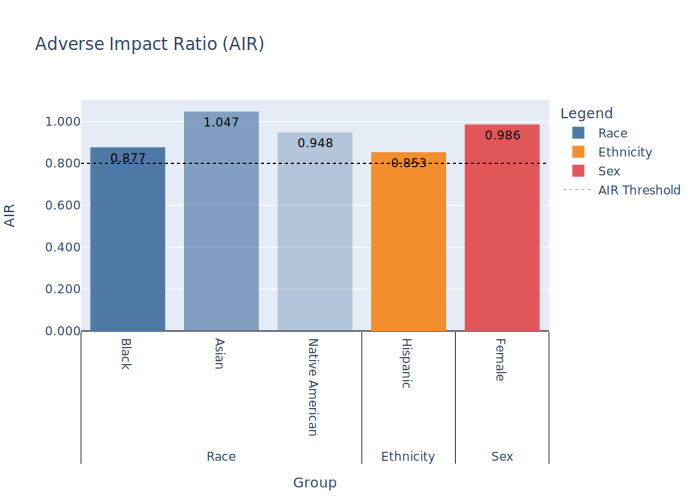

In [6]:
air

## Disparity Calculation: Adverse Impact Ratio

┌───────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                  │ Black, Asian, Native American, Hispanic, Female                             │
│ Reference Groups                  │ White, White, White, Non-Hispanic, Male                                     │
│ Group Categories                  │ Race, Race, Race, Ethnicity, Sex                                            │
│ AIR Threshold                     │ 0.8                                                                         │
│ % Diff Threshold                  │ 0.0                                                                         │
│ Affected Groups                   │                                                                             │
│ Affected Reference                │                                                                             │
│ Affected Categories               │                                                                             │
└───────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

\* Percent Missing: Ethnicity: 13.97%, Race: 13.88%, Sex: 46.40%

## Adverse Impact Ratio Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Black,White,"17,224",13.88%,"1,337.0","1,065.0",79.66%,11.22%,0.877,0.000,No,
Race,Asian,White,"17,224",13.88%,"1,286.0","1,224.0",95.18%,-4.30%,1.047,0.000,No,
Race,Native American,White,"17,224",13.88%,94.0,81.0,86.17%,4.71%,0.948,0.147,No,
Race,White,,"17,224",13.88%,"14,461.0","13,142.0",90.88%,,,,,
Ethnicity,Hispanic,Non-Hispanic,"17,207",13.97%,"2,032.0","1,593.0",78.40%,13.49%,0.853,0.000,No,
Ethnicity,Non-Hispanic,,"17,207",13.97%,"15,175.0","13,943.0",91.88%,,,,,
Sex,Female,Male,"10,719",46.40%,"4,222.0","3,719.0",88.09%,1.28%,0.986,0.043,No,
Sex,Male,,"10,719",46.40%,"6,497.0","5,806.0",89.36%,,,,,


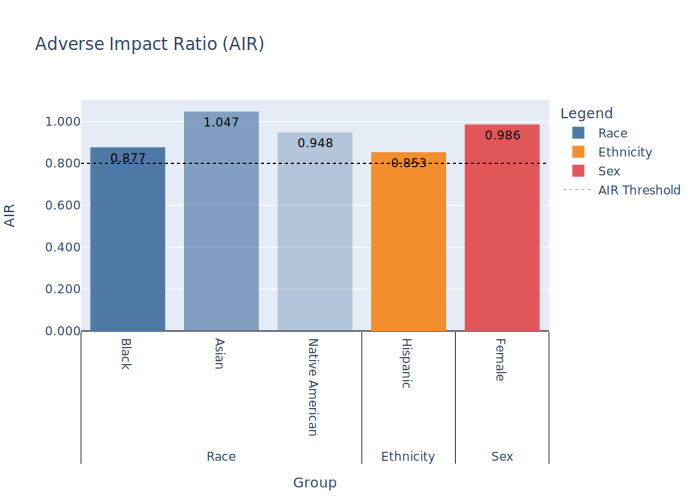

In [7]:
from IPython.display import display
display(air)

### Disparity Summary Table Output

Nearly all the important information about the results of the analysis is contained in the `summary_table`.  The discussion below describes how to access, format, and graph the information in the `summary_table`.

The table can be accessed as a pandas DataFrame by referencing the `summary_table` attribute of the results object:

In [8]:
air.summary_table

,Group Category,Group,Reference Group,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
0,Race,Black,White,17224,0.13880,1337.0,1065.0,0.796559,0.112230,0.876506,1.242621e-38,No,NaN
1,Race,Asian,White,17224,0.13880,1286.0,1224.0,0.951788,-0.042999,1.047315,2.389532e-08,No,NaN
2,Race,Native American,White,17224,0.13880,94.0,81.0,0.861702,0.047087,0.948187,1.467790e-01,No,NaN
3,Race,White,,17224,0.13880,14461.0,13142.0,0.908789,NaN,NaN,NaN,,NaN
4,Ethnicity,Hispanic,Non-Hispanic,17207,0.13965,2032.0,1593.0,0.783957,0.134857,0.853227,1.726213e-82,No,NaN
5,Ethnicity,Non-Hispanic,,17207,0.13965,15175.0,13943.0,0.918814,NaN,NaN,NaN,,NaN
6,Sex,Female,Male,10719,0.46405,4222.0,3719.0,0.880862,0.012781,0.985698,4.300645e-02,No,NaN
7,Sex,Male,,10719,0.46405,6497.0,5806.0,0.893643,NaN,NaN,NaN,,NaN


It can also be viewed as a styled Pandas dataframe by using the SolasAI `sd.ui.show` command.

In [9]:
sd.ui.show(air.summary_table)

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Black,White,"17,224",13.88%,"1,337.0","1,065.0",79.66%,11.22%,0.877,0.000,No,
Race,Asian,White,"17,224",13.88%,"1,286.0","1,224.0",95.18%,-4.30%,1.047,0.000,No,
Race,Native American,White,"17,224",13.88%,94.0,81.0,86.17%,4.71%,0.948,0.147,No,
Race,White,,"17,224",13.88%,"14,461.0","13,142.0",90.88%,,,,,
Ethnicity,Hispanic,Non-Hispanic,"17,207",13.97%,"2,032.0","1,593.0",78.40%,13.49%,0.853,0.000,No,
Ethnicity,Non-Hispanic,,"17,207",13.97%,"15,175.0","13,943.0",91.88%,,,,,
Sex,Female,Male,"10,719",46.40%,"4,222.0","3,719.0",88.09%,1.28%,0.986,0.043,No,
Sex,Male,,"10,719",46.40%,"6,497.0","5,806.0",89.36%,,,,,


The user can generate plots for specific columns of the summary table by using the `plot` method of the results object.  Below, we show examples of plotting the `percent_favorable` and `air` values.

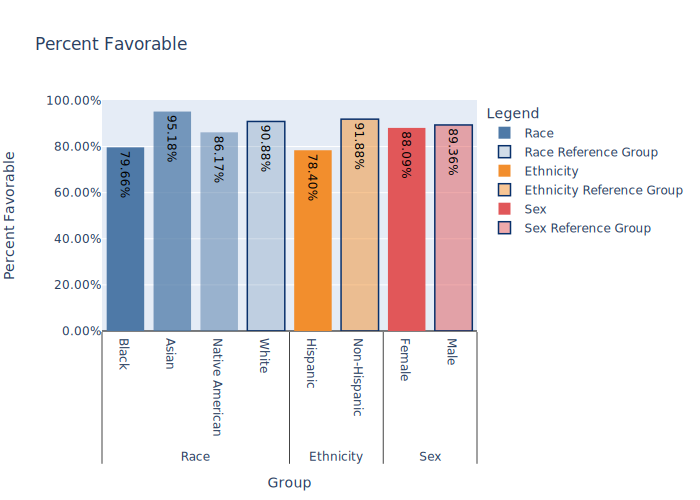

In [10]:
air.plot(column="percent_favorable")

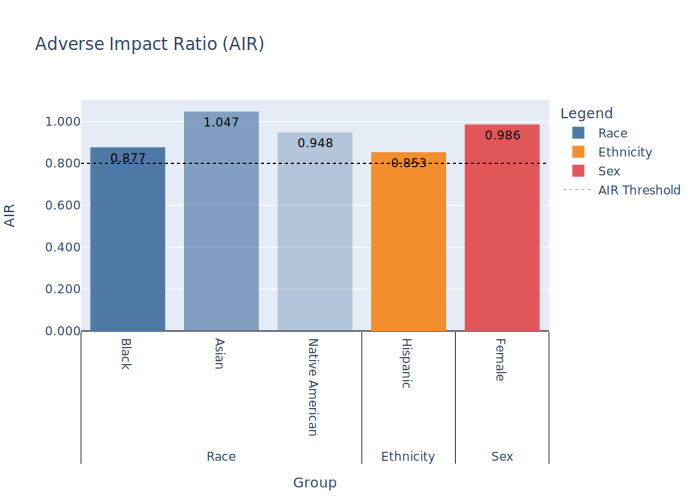

In [11]:
air.plot(column="air")

Results can also be exported. Examples of these commands are shown below.

In [12]:
air.to_csv(file_path=".output/air_summary_table.csv")

In [13]:
air.to_excel(file_path=".output/air_summary_table.xlsx")

In [14]:
air.to_image(file_path=".output/air_plot.svg", column="percent_favorable")

In [15]:
air.to_image(file_path=".output/air_plot.png", column="AIR")

## Utility Functions

`utils.pgrg_ordered` returns a unique and ordered list of protected AND reference groups.  This can be helpful when working with group data or with SolasAI results outside of SolasAI.

In [16]:
protected_and_reference_groups = sd.utils.pgrg_ordered(protected_groups=protected_groups, reference_groups=reference_groups)
protected_and_reference_groups

['Black',
 'Asian',
 'Native American',
 'White',
 'Hispanic',
 'Non-Hispanic',
 'Female',
 'Male']

## Customizing Output

A user can change column names used in all downstream results using the `solas_disparity.const` interface.  This can be very helpful when customizing output for a particular use case.  As an example, a lender might want to make the "Percent Favorable" column display as "Loans Underwritten" or "Accepted Applications", while an employer might want to make the "Percent Favorable" column be "Job Offers" or "Promotions."  

Below is an example of how column names can be customized for the HMDA data use case.

In [17]:
sd.const.FAVORABLE = "Total Loan Offers"
sd.const.PERCENT_FAVORABLE = "Loan Offer Percent"
sd.const.OBSERVATIONS = "Obs. with Data"
sd.const.PERCENT_MISSING = "Pct Obs. Missing Data"
sd.const.PERCENT_DIFFERENCE_FAVORABLE = "Offer Percent Difference"
sd.const.AIR_VALUES = "Adverse Impact Ratio"

Formatting in the table can also be changed, as occurs in the code below.  Here, `sd.ui.AUTO_FORMATTERS` is a dictionary that contains the formats for each of the attributes in the summary table.  When changing the formats, one specifies the key of the dictionary as the attribute from the const file (e.g., "FAVORABLE" when changing `sd.const.FAVORABLE`), and the value as desired python formatter.

In [18]:
sd.ui.AUTO_FORMATTERS['TOTAL'] = "0,.0f"
sd.ui.AUTO_FORMATTERS['FAVORABLE'] = "0,.0f"
sd.ui.AUTO_FORMATTERS['P_VALUES'] = "0.1%"
sd.ui.AUTO_FORMATTERS['PERCENT_MISSING'] = "0.1%"

In [19]:
const_modified_air = sd.adverse_impact_ratio(
    group_data=df,
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=group_categories,
    outcome=df["Low-Priced"],
    sample_weight=None,
    air_threshold=0.80,
    percent_difference_threshold=0.0,
)

The summary table with new variable names and formatted values is printed below.

In [20]:
sd.ui.show(const_modified_air.summary_table)

Group Category,Group,Reference Group,Obs. with Data,Pct Obs. Missing Data,Total,Total Loan Offers,Loan Offer Percent,Offer Percent Difference,Adverse Impact Ratio,P-Values,Practically Significant,Shortfall
Race,Black,White,"17,224",13.9%,"1,337","1,065",79.66%,11.22%,0.877,0.0%,No,
Race,Asian,White,"17,224",13.9%,"1,286","1,224",95.18%,-4.30%,1.047,0.0%,No,
Race,Native American,White,"17,224",13.9%,94,81,86.17%,4.71%,0.948,14.7%,No,
Race,White,,"17,224",13.9%,"14,461","13,142",90.88%,,,,,
Ethnicity,Hispanic,Non-Hispanic,"17,207",14.0%,"2,032","1,593",78.40%,13.49%,0.853,0.0%,No,
Ethnicity,Non-Hispanic,,"17,207",14.0%,"15,175","13,943",91.88%,,,,,
Sex,Female,Male,"10,719",46.4%,"4,222","3,719",88.09%,1.28%,0.986,4.3%,No,
Sex,Male,,"10,719",46.4%,"6,497","5,806",89.36%,,,,,
